In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as kl

class ProbabilityDistribution(tf.keras.Model):
  def call(self, logits, **kwargs):
    # Sample a random categorical action from the given logits.
    return tf.squeeze(tf.random.categorical(logits, 1), axis=-1)


class Model(tf.keras.Model):
  def __init__(self, num_actions):
    super().__init__('mlp_policy')
    # Note: no tf.get_variable(), just simple Keras API!
    self.hidden1 = kl.Dense(128, activation='relu')
    self.hidden2 = kl.Dense(128, activation='relu')
    self.hidden3 = kl.Dense(128, activation='relu')
    self.hidden4 = kl.Dense(128, activation='relu')
    self.hidden5 = kl.Dense(128, activation='relu')
    self.hidden6 = kl.Dense(128, activation='relu')
    self.value = kl.Dense(1, name='value')
    # Logits are unnormalized log probabilities.
    self.logits = kl.Dense(num_actions, name='policy_logits')
    self.dist = ProbabilityDistribution()

  def call(self, inputs, **kwargs):
    # Inputs is a numpy array, convert to a tensor.
    x = tf.convert_to_tensor(inputs)
    x = self.hidden1(x)
    x = self.hidden2(x)
    x = self.hidden3(x)
    x = self.hidden4(x)
    # Separate hidden layers from the same input tensor.
    hidden_logs = self.hidden5(x)
    hidden_vals = self.hidden6(x)
    return self.logits(hidden_logs), self.value(hidden_vals)

  def action_value(self, obs):
    # Executes `call()` under the hood.
    logits, value = self.predict_on_batch(obs)
    action = self.dist.predict_on_batch(logits)
    # Another way to sample actions:
    #   action = tf.random.categorical(logits, 1)
    # Will become clearer later why we don't use it.
    return np.squeeze(action, axis=-1), np.squeeze(value, axis=-1)

In [2]:
import game2048_env
import gym

env = game2048_env.Game2048Env()
env.seed(0)
env.set_max_tile(2048)
# env.set_illegal_move_reward(0)
model = Model(num_actions=4)


obs = env.reset()
action, value = model.action_value(obs)
print(action, value)

3 [-0.00846089]


In [3]:
import tensorflow.keras.losses as kls
import tensorflow.keras.optimizers as ko
from IPython.display import clear_output

class A2CAgent:
  def __init__(self, model, lr=7e-3, gamma=0.99, value_c=0.5, entropy_c=1e-4):
    # `gamma` is the discount factor
    self.gamma = gamma
    # Coefficients are used for the loss terms.
    self.value_c = value_c
    self.entropy_c = entropy_c

    self.model = model
    self.model.compile(
      optimizer=ko.RMSprop(lr=lr),
      # Define separate losses for policy logits and value estimate.
      loss=[self._logits_loss, self._value_loss])
    self.model.load_weights('./rl_weights.h5')

  def test(self, env, render=True):
    obs, done, ep_reward = env.reset(), False, 0
    while not done:
      action, _ = self.model.action_value(obs)
      obs, reward, done, _ = env.step(action)
      ep_reward += reward
      if render:
        env.render()
    return ep_reward

  def _value_loss(self, returns, value):
    # Value loss is typically MSE between value estimates and returns.
    return self.value_c * kls.mean_squared_error(returns, value)

  def _logits_loss(self, actions_and_advantages, logits):
    # A trick to input actions and advantages through the same API.
    actions, advantages = tf.split(actions_and_advantages, 2, axis=-1)

    # Sparse categorical CE loss obj that supports sample_weight arg on `call()`.
    # `from_logits` argument ensures transformation into normalized probabilities.
    weighted_sparse_ce = kls.SparseCategoricalCrossentropy(from_logits=True)

    # Policy loss is defined by policy gradients, weighted by advantages.
    # Note: we only calculate the loss on the actions we've actually taken.
    actions = tf.cast(actions, tf.int32)
    policy_loss = weighted_sparse_ce(actions, logits, sample_weight=advantages)

    # Entropy loss can be calculated as cross-entropy over itself.
    probs = tf.nn.softmax(logits)
    entropy_loss = kls.categorical_crossentropy(probs, probs)

    # We want to minimize policy and maximize entropy losses.
    # Here signs are flipped because the optimizer minimizes.
    return policy_loss - self.entropy_c * entropy_loss

  def train(self, env, batch_sz=64, updates=250):
    # Storage helpers for a single batch of data.
    actions = np.empty((batch_sz,), dtype=np.int32)
    rewards, dones, values = np.empty((3, batch_sz))
    observations = np.empty((batch_sz,) + (1, 16))

    # Training loop: collect samples, send to optimizer, repeat updates times.
    ep_rewards = [0.0]
    next_obs = env.reset()
    for update in range(updates):
      for step in range(batch_sz):
        observations[step] = next_obs.copy()
        actions[step], values[step] = self.model.action_value(next_obs)
        next_obs, rewards[step], dones[step], _ = env.step(actions[step])

        ep_rewards[-1] += rewards[step]
        if dones[step]:
          ep_rewards.append(0.0)
          next_obs = env.reset()
          # clear_output(wait=True)
          tf.print("Episode: %03d, Reward: %03d" % (
            len(ep_rewards) - 1, ep_rewards[-2]))
        #   logging.info("Episode: %03d, Reward: %03d" % (
        #     len(ep_rewards) - 1, ep_rewards[-2]))

      _, next_value = self.model.action_value(next_obs)

      returns, advs = self._returns_advantages(rewards, dones, values, next_value)
      # A trick to input actions and advantages through same API.
      acts_and_advs = np.concatenate([actions[:, None], advs[:, None]], axis=-1)

      # Performs a full training step on the collected batch.
      # Note: no need to mess around with gradients, Keras API handles it.
      losses = self.model.train_on_batch(observations, [acts_and_advs, returns])

    #   logging.debug("[%d/%d] Losses: %s" % (update + 1, updates, losses))

    return ep_rewards

  def _returns_advantages(self, rewards, dones, values, next_value):
    # `next_value` is the bootstrap value estimate of the future state (critic).
    returns = np.append(np.zeros_like(rewards), next_value, axis=-1)

    # Returns are calculated as discounted sum of future rewards.
    for t in reversed(range(rewards.shape[0])):
      returns[t] = rewards[t] + self.gamma * returns[t + 1] * (1 - dones[t])
    returns = returns[:-1]

    # Advantages are equal to returns - baseline (value estimates in our case).
    advantages = returns - values

    return returns, advantages

In [4]:
agent = A2CAgent(model)

In [4]:
rewards_history = agent.train(env, batch_sz=64, updates=1000)
# print("Finished training, testing...")
# agent.test(env)

rd: 340
Episode: 434, Reward: 024
Episode: 435, Reward: 520
Episode: 436, Reward: 424
Episode: 437, Reward: 276
Episode: 438, Reward: 316
Episode: 439, Reward: 324
Episode: 440, Reward: 132
Episode: 441, Reward: 568
Episode: 442, Reward: 480
Episode: 443, Reward: 268
Episode: 444, Reward: 524
Episode: 445, Reward: 440
Episode: 446, Reward: 240
Episode: 447, Reward: 000
Episode: 448, Reward: 424
Episode: 449, Reward: 020
Episode: 450, Reward: 560
Episode: 451, Reward: 212
Episode: 452, Reward: 064
Episode: 453, Reward: 692
Episode: 454, Reward: 608
Episode: 455, Reward: 560
Episode: 456, Reward: 692
Episode: 457, Reward: 652
Episode: 458, Reward: 004
Episode: 459, Reward: 240
Episode: 460, Reward: 456
Episode: 461, Reward: 192
Episode: 462, Reward: 200
Episode: 463, Reward: 400
Episode: 464, Reward: 000
Episode: 465, Reward: 128
Episode: 466, Reward: 240
Episode: 467, Reward: 608
Episode: 468, Reward: 468
Episode: 469, Reward: 152
Episode: 470, Reward: 400
Episode: 471, Reward: 536
Epis

In [5]:
env.close()

In [6]:
agent.model.save_weights('./rl_weightsv2.h5')

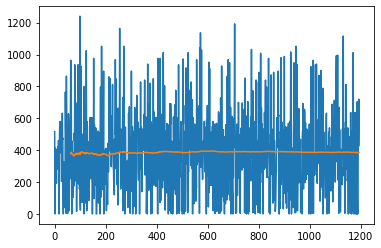

In [56]:
import matplotlib.pyplot as plt
import pandas as pd
s = pd.Series(rewards_history)
ss = s.expanding(min_periods=64).mean()
plt.plot(s)
plt.plot(ss)

In [5]:
import PIL.Image as Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
def render_env(env, output_text, info):
    # clear_output(wait=True)
    # print(output_text)
    if info['illegal_move']:
        print("Ended because of illegal move")
    rgb = env.render('rgb_array')
    
    return Image.fromarray(rgb)
    # display(Image.fromarray(rgb))

Ended because of illegal move


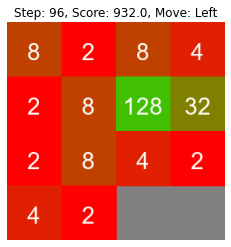

In [22]:
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rcParams['animation.ffmpeg_path'] = r'C:\ffmpeg\bin\ffmpeg.exe'

done = False
observation = env.reset()
directions = ["Up", "Right", "Down", "Left"]
step = 0
images = []
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axis('off')
while not done:
    action, value = agent.model.action_value(observation)
    next_observation, reward, done, info = env.step(action)
    step += 1
    t = f"Step: {step}, Score: {env.score}, Move: {directions[action]}"
    title = plt.text(0.5,1.01,t, ha="center",va="bottom",transform=ax.transAxes, fontsize="large")
    image = render_env(env, f"Step: {step}, Score: {env.score}", info)
    im = ax.imshow(image, animated=True)
    images.append([im, title])
    observation = next_observation.copy()
ani = animation.ArtistAnimation(fig, images, blit=False, repeat_delay=2000)
ani.save('animation2.gif', fps=4)
plt.show()